In [1]:
from glob import glob

path = '/kaggle/input/agricultural-crops-image-classification/Agricultural-crops'

label_paths = sorted(glob(path+'/*'))

len(label_paths)

30

There are 30 class labels of crops

In [2]:
from PIL import Image
import cv2 as cv

images = [[] for _ in range(len(label_paths))]
for label in range(len(label_paths)):    
    image_paths = glob(label_paths[label]+"/*")        
    for ip in image_paths:        
        images[label].append(cv.imread(ip))        

In [3]:
import pandas as pd

sizes, labels = [],[]
for label in range(len(label_paths)):
    sizes.append(len(images[label]))
    labels.append(label)
num_by_label = pd.DataFrame({'label': labels, 'number of elements': sizes})
num_by_label

,label,number of elements
0,0,32
1,1,29
2,2,31
3,3,23
4,4,28
5,5,30
6,6,39
7,7,33
8,8,21
9,9,31


Every label has about 20-40 elements

In [4]:
shapes = pd.DataFrame([arr.shape for arr in images[0]], columns=['Rows', 'Columns', 'Channels'])
shapes.head()

,Rows,Columns,Channels
0,225,225,3
1,251,201,3
2,183,275,3
3,182,277,3
4,225,225,3


From here, we can see that images have differrent number of rows and columns. So we need to resize images to one shape.

In [5]:
H, W = 128, 128
reshaped_images = []
labels = []

for label in range(len(images)):
    for image in images[label]:
        reshaped_image = cv.resize(image, (H, W))
        reshaped_images.append(reshaped_image)
        labels.append(label)
        
len(reshaped_images), len(labels), reshaped_images[0].shape

(829, 829, (128, 128, 3))

We have 829 images in total. And now every image has a shape of (128, 128, 3)

In [6]:
import numpy as np
X = np.stack(reshaped_images, axis=0)
y = np.stack(labels, axis=0)
X = X.reshape(X.shape[0], -1)
X.shape, y.shape

((829, 49152), (829,))

We collected all input data, and labels into 2 numpy arrays. Also, we flattened our images into 1 dimension.

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

Here, we split data into test and train, with test_size=0.1

In [8]:
class SoftmaxRegression:
    def __init__(self, num_classes, learning_rate=0.05, epochs=100):
        self.num_classes = num_classes
        self.learning_rate = learning_rate
        self.epochs = epochs

    def _softmax(self, X):
        exp_scores = np.exp(X - np.max(X, axis=1, keepdims=True))
        return exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

    def _one_hot_encoding(self, y):
        one_hot = np.zeros((len(y), self.num_classes))
        one_hot[range(len(y)), y] = 1
        return one_hot

    def train(self, X, y):
        y_one_hot = self._one_hot_encoding(y)
        self.weights = np.zeros((X.shape[1], self.num_classes))

        for epoch in range(self.epochs):
            scores = X.dot(self.weights)
            predictions = self._softmax(scores)

            # Compute the gradient
            error = predictions - y_one_hot
            gradient = X.T.dot(error) / len(y)

            # Update weights using gradient descent
            self.weights -= self.learning_rate * gradient

    def predict(self, X):
        scores = X.dot(self.weights)
        predictions = self._softmax(scores)
        return np.argmax(predictions, axis=1)

Softmax Regression with learning rate=0.001, and 1000 epochs

In [9]:
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from tqdm import tqdm

num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=21)


num_classes = 30

accuracies = []

for train_idx, test_idx in tqdm(kf.split(X)):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    softmax_model = SoftmaxRegression(num_classes=num_classes)
    softmax_model.train(X_train, y_train)
    
    predictions = softmax_model.predict(X_test)

    accuracy = np.mean(predictions == y_test)*100
    accuracies.append(accuracy)

average_accuracy = np.mean(accuracies)

print("Average Accuracy: {:.2f}%".format(average_accuracy))

5it [04:01, 48.29s/it]

Average Accuracy: 15.68%


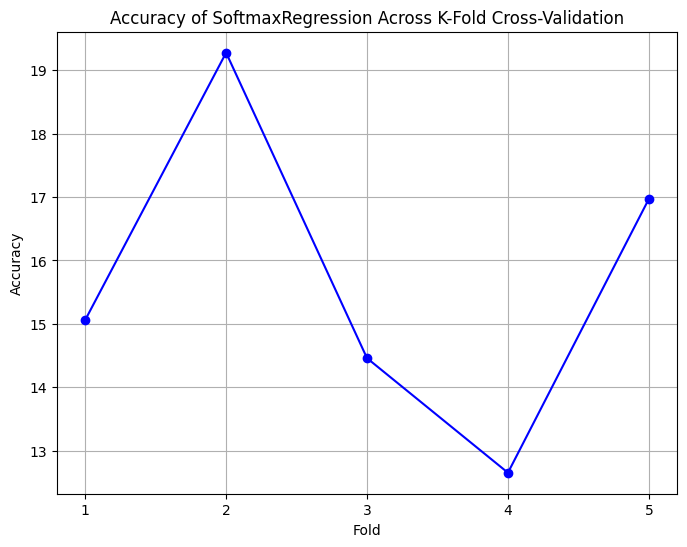

In [10]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_folds + 1), accuracies, marker='o', linestyle='-', color='b')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.title('Accuracy of SoftmaxRegression Across K-Fold Cross-Validation')
plt.xticks(range(1, num_folds + 1))
plt.grid(True)
plt.show()


In [11]:
class SVM:
    def __init__(self, learning_rate=0.05, lambda_param=0.03, epochs=100):
        self.lr = learning_rate
        self.lambda_param = lambda_param
        self.epochs = epochs
        self.w = None
        self.b = None

    def fit(self, X, y):
        n_samples, n_features = X.shape
        y_ = np.where(y <= 0, -1, 1)
        self.w = np.zeros(n_features)
        self.b = 0

        for _ in range(self.epochs):
            for idx, x_i in enumerate(X):
                condition = y_[idx] * (np.dot(x_i, self.w) - self.b) >= 1
                if condition:
                    self.w -= self.lr * (2 * self.lambda_param * self.w)
                else:
                    self.w -= self.lr * (2 * self.lambda_param * self.w - np.dot(x_i, y_[idx]))
                    self.b -= self.lr * y_[idx]

    def predict(self, X):
        return np.sign(np.dot(X, self.w) - self.b)

Here is our SVM algorithm class: we used learnig rate = 0.05, epochs=100

In [12]:
accuracies = []

for train_idx, test_idx in tqdm(kf.split(X)):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    svm = SVM()
    svm.fit(X_train, y_train)
    predictions = svm.predict(X_test)
    accuracy = np.mean(predictions == y_test)*100
    accuracies.append(accuracy)    

average_accuracy = np.mean(accuracies)

print("Average Accuracy: {:.2f}%".format(average_accuracy))

5it [01:19, 15.82s/it]

Average Accuracy: 3.50%


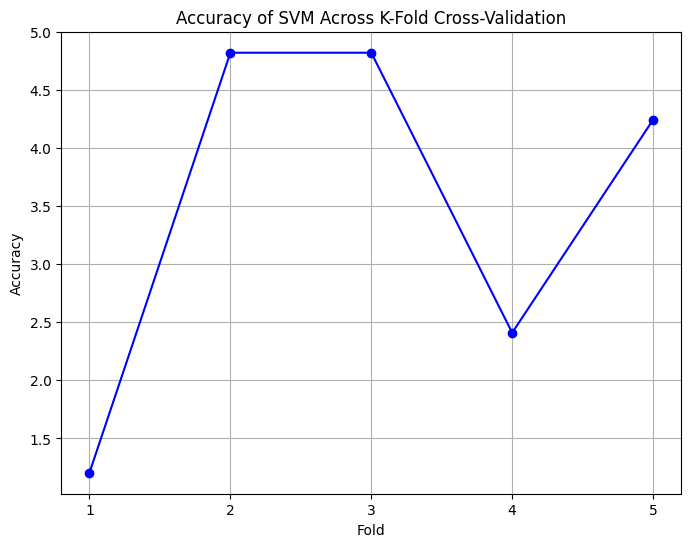

In [13]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_folds + 1), accuracies, marker='o', linestyle='-', color='b')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.title('Accuracy of SVM Across K-Fold Cross-Validation')
plt.xticks(range(1, num_folds + 1))
plt.grid(True)
plt.show()


Both of the models showed bad results: SVM - 3.5% at average, Softmax Regression - 15%. I think, that SVM does not match this dataset, and we should use Softmax Regression.

Also, there are 2 factors that decrease our accuracy:

1) There are only 890 elements(which is really few), and 30 classes(which is huge, when comparing to number of elements), and when we divide our data into test and train, it is really hard to save a balance

2) Pictures initially had differrent sizes, and even differrent width/height ratios. When we did reshaping, we lost a lot of important information.